# Bifurcation

The concept of **bifurcation** concerns the **parameter space** of a dynamical system and indicates a point of **structural instability** in its dynamics.

At a bifurcation point, a small perturbation in the system’s parameters can lead to a **qualitative change in the structure of its phase portrait**—such as a change in the **number or stability of equilibria**, the **emergence or disappearance of attractors**, or the **onset of oscillatory behavior**.

In [55]:
from sympy import Matrix, Expr  # Core imports
from sympy import symbols, Eq, solve, S, diff
from typing import Union, List, Dict
def compute_jacobian(
    state_vars: List[Union[symbols, Expr]], 
    system_exprs: List[Union[Expr, float, int]],
    simplify: bool = True
) -> Matrix:
    """
    Compute the Jacobian matrix for a dynamical system symbolically.
    
    Args:
        state_vars: List of state variables (e.g., [x, y, z]).
        system_exprs: List of dynamical system equations (e.g., [dxdt, dydt, dzdt]).
        simplify: If True, simplify the Jacobian expressions symbolically.
        
    Returns:
        Jacobian matrix (sympy.Matrix).
        
    Raises:
        ValueError: If dimensions mismatch.
    """
    # Validate input dimensions
    if len(system_exprs) == 0 or len(state_vars) == 0:
        raise ValueError("Empty system or state variables list.")
    
    # Compute Jacobian
    jacobian = []
    for expr in system_exprs:
        row = [diff(expr, var) for var in state_vars]
        jacobian.append(row)
    
    J = Matrix(jacobian)
    if simplify:
        J.simplify()
    return J
from sympy import S, Eq, solve
from typing import List, Dict, Union
from sympy.core.expr import Expr
from sympy import symbols
from sympy import S, Eq, solve, Lt, Le, Gt, Ge, Ne, simplify
from sympy.solvers.inequalities import solve_univariate_inequality
from typing import List, Dict, Union, Optional
from sympy.core.expr import Expr
from sympy import symbols

def solve_equation(
    variables: List[symbols],
    expression: Union[Expr, float, int],
    target_value: Union[Expr, float, int] = 0,
    real_only: bool = True,
    verbose: bool = True,
    inequality: Optional[str] = None  # '>', '<', '>=', '<=', '!='
) -> List[Dict]:
    """
    Solve expression == target_value (or inequality) for given variables.

    Args:
        variables: List of symbolic variables (e.g., [x, y]).
        expression: SymPy expression or constant (e.g., x**2 + y - 3).
        target_value: Value to solve for (default: 0).
        real_only: If True, filter out complex solutions.
        verbose: Print solutions if True.
        inequality: If provided ('>', '<', '>=', '<=', '!='), solve as inequality.

    Returns:
        List of dictionaries with variable: value pairs (or intervals for inequalities).
    """
    expr = S(expression)
    target = S(target_value)
    
    # Handle inequalities (only for single-variable cases)
    if inequality:
        if len(variables) != 1:
            raise ValueError("Inequalities only supported for single-variable problems.")
        
        var = variables[0]
        if inequality == '>':
            ineq_expr = Gt(expr, target)
        elif inequality == '<':
            ineq_expr = Lt(expr, target)
        elif inequality == '>=':
            ineq_expr = Ge(expr, target)
        elif inequality == '<=':
            ineq_expr = Le(expr, target)
        elif inequality == '!=':
            ineq_expr = Ne(expr, target)
        else:
            raise ValueError("Invalid inequality. Use '>', '<', '>=', '<=', or '!='.")
        
        # Solve the inequality
        solution = solve_univariate_inequality(ineq_expr, var, relational=False)
        
        if verbose:
            print(f"\nSolving: {expr} {inequality} {target}")
            print("Solution:", solution)
        
        return [solution]  # Returns solution as an interval
    
    # Otherwise, solve as an equation
    solutions = solve(Eq(expr, target), *variables, real_only=real_only)
    
    # Format solutions as dictionaries
    result = []
    if not isinstance(solutions, (list, tuple, dict)):
        if solutions == True:  # Equation is always true
            return [{}]
        elif solutions == False:  # No solution
            return []
        else:  # Single solution
            return [{variables[0]: solutions}]
    
    for sol in solutions:
        if isinstance(sol, dict):
            result.append(sol)
        elif isinstance(sol, (tuple, list)):
            result.extend(sol)
        else:
            result.append({variables[0]: sol})
    
    if verbose:
        print(f"\nSolving: {expr} = {target}")
        if not result:
            print("No solutions found.")
        else:
            for i, sol in enumerate(result, 1):
                print(f"Solution {i}: {sol}")
    
    return result

## 1. Saddle-node

> A saddle-node bifurcation occurs when two fixed points—one stable (node) and one unstable (saddle)—collide and annihilate each other as a parameter is varied.
> It it the **change of equilibria**.

$$\dot x = \mu - x^2 = f(x)$$

$$J(x) = \frac{\partial f}{\partial x} = -2x$$

$$J(0) = 0$$

In [68]:
def build_system1():
    from sympy import symbols, diff, Matrix
    
    x, mu, y = symbols('x mu y')
    
    # Define the system (example: 2D saddle-node)
    f = mu - x**2
    return {'vector_field': f, 'states': [x], 'parameters': {'mu': mu}, 'y': y}
    

In [69]:
system = build_system1()
vector_field, x, mu, y = system['vector_field'], system['states'][0], system['parameters']['mu'], system['y']

# Jacobian matrix
J = compute_jacobian([x, mu], [vector_field, mu])
print("Jacobian:")
print(J)
eigenvalues = J.eigenvals()
print("Eigenvalues:")
print(eigenvalues)

Jacobian:
Matrix([[-2*x, 1], [0, 1]])
Eigenvalues:
{1: 1, -2*x: 1}


In [70]:
for eigenvalue in eigenvalues.keys():
    print("\nEigenvalue:", eigenvalue)
    # Solve eigenvalue < 0
    solution = solve_equation([x], eigenvalue, inequality='<')
    print("Solution where eigenvalue < 0:", solution)


Eigenvalue: 1

Solving: 1 < 0
Solution: EmptySet
Solution where eigenvalue < 0: [EmptySet]

Eigenvalue: -2*x

Solving: -2*x < 0
Solution: Interval.open(0, oo)
Solution where eigenvalue < 0: [Interval.open(0, oo)]


In [71]:
# 1. find fixed points
fixed_points = solve(Eq(vector_field, 0), x)
print("Fixed points:", fixed_points)  # Output: [-sqrt(mu), sqrt(mu)]

# 2. Stability analysis
dfdx = diff(vector_field, x)
print("\nStability:")

for x_fp in fixed_points:
    stability = dfdx.subs(x, x_fp)
    
    # Proper symbolic comparison
    is_stable = simplify(Lt(stability, 0))
    is_unstable = simplify(Gt(stability, 0))
    
    if is_stable == True:
        stability_type = "Stable"
    elif is_unstable == True:
        stability_type = "Unstable"
    else:
        stability_type = "Half-stable"

    print(f"At x = {x_fp}: f' = {stability} ({stability_type})")


# 3. Bifurcation analysis
print("\nBifurcation occurs at μ = 0:")
print("- For μ > 0: Two fixed points (1 stable, 1 unstable)")
print("- For μ = 0: One half-stable fixed point")
print("- For μ < 0: No real fixed points")


Fixed points: [-sqrt(mu), sqrt(mu)]

Stability:
At x = -sqrt(mu): f' = 2*sqrt(mu) (Half-stable)
At x = sqrt(mu): f' = -2*sqrt(mu) (Half-stable)

Bifurcation occurs at μ = 0:
- For μ > 0: Two fixed points (1 stable, 1 unstable)
- For μ = 0: One half-stable fixed point
- For μ < 0: No real fixed points


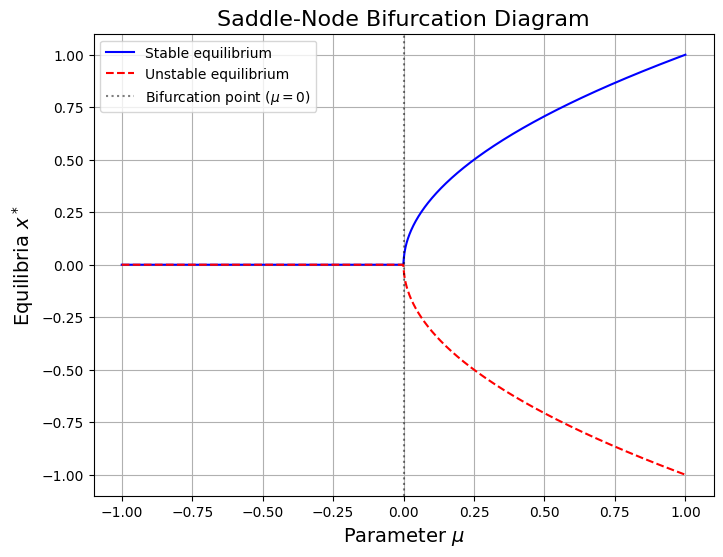

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameter range
mu_values = np.linspace(-1, 1, 1000)

# Compute equilibria: x^2 = mu => x = ±sqrt(mu)
stable_eq = np.sqrt(np.maximum(0, mu_values))  # Stable branch (real part)
unstable_eq = -np.sqrt(np.maximum(0, mu_values))  # Unstable branch

# Plot
plt.figure(figsize=(8, 6))
plt.plot(mu_values, stable_eq, 'b-', label='Stable equilibrium')
plt.plot(mu_values, unstable_eq, 'r--', label='Unstable equilibrium')
plt.xlabel('Parameter $\mu$', fontsize=14)
plt.ylabel('Equilibria $x^*$', fontsize=14)
plt.title('Saddle-Node Bifurcation Diagram', fontsize=16)
plt.axvline(0, color='k', linestyle=':', alpha=0.5, label='Bifurcation point ($\mu=0$)')
plt.legend()
plt.grid(True)


At $\mu = 0$, the numbers of equilibria changed.

In [73]:
from ipywidgets import interact

@interact(mu=(-1.0, 1.0, 0.1))
def plot_state_space(mu=0.0):
    x = np.linspace(-3, 3, 100)
    dx = mu - x**2
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, dx, 'k-', lw=2)
    plt.axhline(0, color='gray', linestyle='--')
    
    if mu >= 0:
        plt.scatter([np.sqrt(mu), -np.sqrt(mu)], [0, 0], 
                   c=['b', 'r'], s=100)
    
    plt.title(f'$\dot x$ vs x ($\mu$={mu:.1f})')
    plt.xlabel('State $x$')
    plt.ylabel('$\dot x$')
    plt.grid(True)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='mu', max=1.0, min=-1.0), Output()), _dom_classes=('w…

## Pitchfork

> A **pitchfork bifurcation** occurs when a system transitions from one fixed point to three as a parameter changes.

There are two types:
> + Supercritical: Stable fixed point splits into 3 (2 stable, 1 unstable).
> + Subcritical: Unstable fixed point splits into 3 (2 unstable, 1 stable).


(**Stability** and **numbers of fixed points** changed)

$$\dot x = \mu x-x^3$$

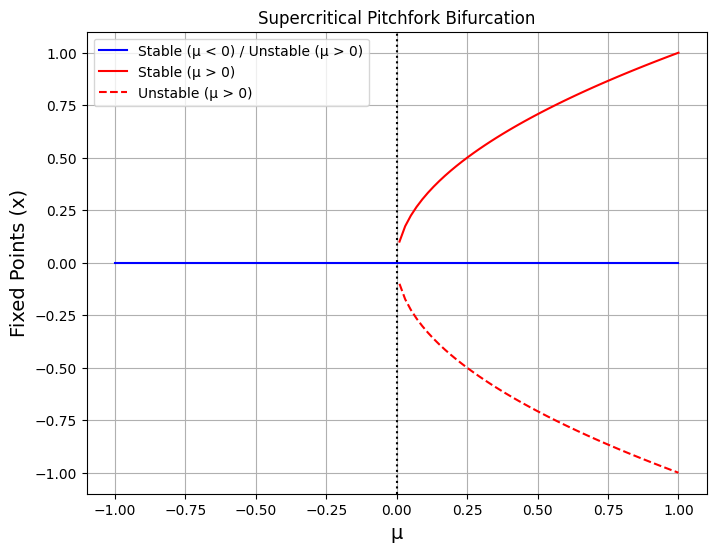

In [75]:
import numpy as np
import matplotlib.pyplot as plt

mu = np.linspace(-1, 1, 100)
x0 = np.zeros_like(mu)                   # x = 0 branch
x_stable = np.sqrt(np.maximum(0, mu))    # x = +√μ branch
x_unstable = -np.sqrt(np.maximum(0, mu)) # x = -√μ branch

plt.figure(figsize=(8, 6))
plt.plot(mu, x0, 'b-', label='Stable (μ < 0) / Unstable (μ > 0)')
plt.plot(mu[mu >= 0], x_stable[mu >= 0], 'r-', label='Stable (μ > 0)')
plt.plot(mu[mu >= 0], x_unstable[mu >= 0], 'r--', label='Unstable (μ > 0)')
plt.xlabel('μ', fontsize=14)
plt.ylabel('Fixed Points (x)', fontsize=14)
plt.title('Supercritical Pitchfork Bifurcation')
plt.axvline(0, color='k', linestyle=':')
plt.legend()
plt.grid()
plt.show()

In [94]:
from sympy import symbols, diff, Eq, solve, root

def build_system2():
    x, mu = symbols('x mu')
    f = mu - x**3
    return {'vector_field': f, 'states': [x], 'parameters': {'mu': mu}}

# System setup
system = build_system2()
f = system['vector_field']
x = system['states'][0]
mu = system['parameters']['mu']

# 1. Find fixed points
fixed_points = solve(Eq(f, 0), x)
print(f"Fixed points: {fixed_points}")  # Output: [mu**(1/3)]

# 2. Stability analysis
dfdx = diff(f, x)
print("\nStability:")
for x_fp in fixed_points:
    stability = dfdx.subs(x, x_fp)
    stability.simplify()
    print(f"At x = {x_fp}: f = {stability}")

# 3. Bifurcation conclusion
print("\nBifurcation Analysis:")
print("- For mu < 0, Fix points: x = 0 (stable)")
print("- For mu = 0, Fix points: x = 0 (Non-hyperbolic (bifurcation))")
print("- For mu > 0, Fix points: x = 0 (unstable), x=$\pm \sqrt \mu$, stable")


Fixed points: [mu**(1/3), -mu**(1/3)/2 - sqrt(3)*I*mu**(1/3)/2, -mu**(1/3)/2 + sqrt(3)*I*mu**(1/3)/2]

Stability:
At x = mu**(1/3): f = -3*mu**(2/3)
At x = -mu**(1/3)/2 - sqrt(3)*I*mu**(1/3)/2: f = -3*(-mu**(1/3)/2 - sqrt(3)*I*mu**(1/3)/2)**2
At x = -mu**(1/3)/2 + sqrt(3)*I*mu**(1/3)/2: f = -3*(-mu**(1/3)/2 + sqrt(3)*I*mu**(1/3)/2)**2

Bifurcation Analysis:
- For mu < 0, Fix points: x = 0 (stable)
- For mu = 0, Fix points: x = 0 (Non-hyperbolic (bifurcation))
- For mu > 0, Fix points: x = 0 (unstable), x=$\pm \sqrt \mu$, stable


In [79]:
from ipywidgets import interact

@interact(mu=(-1.0, 1.0, 0.1))
def plot_pitchfork(mu=0.0):
    x = np.linspace(-2, 2, 100)
    dxdt = mu * x - x**3
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, dxdt, 'b-', label=f'$\dot x = {mu:.1f}x - x^3$')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('$\dot x$')
    plt.title(f'Pitchfork Bifurcation ($\mu = {mu:.1f}$)')
    plt.grid()
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='mu', max=1.0, min=-1.0), Output()), _dom_classes=('w…

## Hopf

In [132]:
from sympy import symbols, Matrix, diff, Eq, solve
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider

def build_transcritical_system():
    x, mu = symbols('x mu')
    f = mu*x - x**2  # Transcritical normal form
    return {'vector_field': Matrix([f]), 
            'states': [x], 
            'parameters': {'mu': mu}}

# System setup
system = build_transcritical_system()
f = system['vector_field'][0]  # Extract scalar equation
x = system['states'][0]
mu = system['parameters']['mu']

# 1. Find fixed points
fixed_points = solve(Eq(f, 0), x)
print(f"Fixed points: {fixed_points}")  # [0, μ]

# 2. Stability analysis
J = diff(f, x)  # Jacobian is just the derivative in 1D
for x_fp in fixed_points:
    stability = J.subs(x, x_fp)
    stability.simplify()
    print(f"At x = {x_fp}: f' = {stability}")

# 3. Bifurcation condition
critical_mu = solve(Eq(J.subs(x, 0), mu))
print(f"\n Bifurcation occurs at μ = {critical_mu}")



Fixed points: [0, mu]
At x = 0: f' = mu
At x = mu: f' = -mu

 Bifurcation occurs at μ = []


In [103]:
from ipywidgets import interact, FloatSlider
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the Hopf system
def hopf_rhs(X, t, mu):
    x, y = X
    dxdt = mu*x - y - x*(x**2 + y**2)  # Supercritical Hopf
    dydt = x + mu*y - y*(x**2 + y**2)
    return [dxdt, dydt]

# Interactive plotting function
def plot_hopf(mu):
    # Time points and initial condition
    t = np.linspace(0, 50, 1000)
    X0 = [0.5, 0.5]  # Initial (x,y)
    
    # Numerical solution
    sol = odeint(hopf_rhs, X0, t, args=(mu,))
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Phase portrait
    ax1.plot(sol[:,0], sol[:,1], 'b-', linewidth=1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'Phase Portrait (μ = {mu:.2f})')
    ax1.grid(True)
    
    # Time series
    ax2.plot(t, sol[:,0], 'r-', label='x(t)')
    ax2.plot(t, sol[:,1], 'g-', label='y(t)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('State')
    ax2.set_title('Time Series')
    ax2.legend()
    ax2.grid(True)
    
    # Add limit cycle if μ > 0
    if mu > 0:
        theta = np.linspace(0, 2*np.pi, 100)
        r = np.sqrt(mu)
        ax1.plot(r*np.cos(theta), r*np.sin(theta), 'k--', label='Limit cycle')
        ax1.legend()
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(
    plot_hopf,
    mu=FloatSlider(
        value=-0.5,
        min=-1.0,
        max=1.0,
        step=0.05,
        description='μ (bifurcation parameter):',
        continuous_update=True
    )
);

interactive(children=(FloatSlider(value=-0.5, description='μ (bifurcation parameter):', max=1.0, min=-1.0, ste…

## SNIC (Saddle-Node on Invariant Circle)

> A limit cycle appears through collision with fixed point ==(Emerging of new structure)==

In [105]:
from sympy import symbols, Matrix, diff, Eq, solve, cos, sin
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def build_snic_system():
    theta, mu = symbols('theta mu')
    f = (1 - cos(theta)) + (1 + cos(theta)) * mu  # Theta-neuron model
    return {'vector_field': f, 
            'states': [theta], 
            'parameters': {'mu': mu}}

# System setup
system = build_snic_system()
f = system['vector_field']
theta = system['states'][0]
mu = system['parameters']['mu']

In [117]:
# Find fixed points (θ ∈ [0, 2π])
fixed_points = solve(Eq(f, 0), theta)
print(f"Fixed points: {fixed_points}")

# Stability analysis
dfdtheta = diff(f, theta)
for theta_fp in fixed_points:
    stability = dfdtheta.subs(theta, theta_fp)
    stability.simplify()
    print(f"At θ = {theta_fp}: Stability = {stability}")

Fixed points: [-acos(-(mu + 1)/(mu - 1)) + 2*pi, acos((-mu - 1)/(mu - 1))]
At θ = -acos(-(mu + 1)/(mu - 1)) + 2*pi: Stability = mu*sqrt(1 - (mu + 1)**2/(mu - 1)**2) - sqrt(1 - (mu + 1)**2/(mu - 1)**2)
At θ = acos((-mu - 1)/(mu - 1)): Stability = -mu*sqrt(-(-mu - 1)**2/(mu - 1)**2 + 1) + sqrt(-(-mu - 1)**2/(mu - 1)**2 + 1)


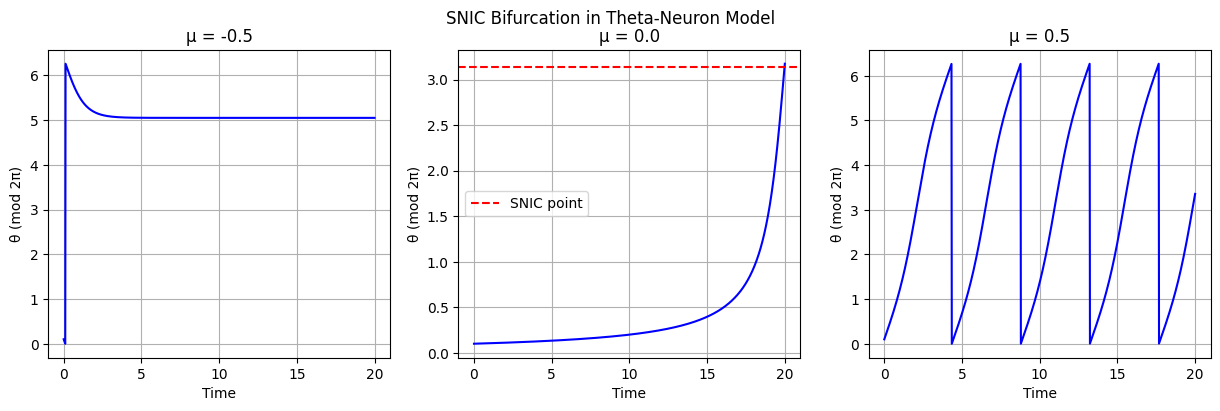

In [118]:
def snic_rhs(theta, t, mu):
    return (1 - np.cos(theta)) + (1 + np.cos(theta)) * mu

# Phase portraits for critical μ values
mu_values = [-0.5, 0.0, 0.5]
t = np.linspace(0, 20, 1000)
theta0 = 0.1

plt.figure(figsize=(15, 4))
for i, mu_val in enumerate(mu_values):
    sol = odeint(snic_rhs, theta0, t, args=(mu_val,))
    
    # Wrap theta to [0, 2π]
    sol_wrapped = sol % (2 * np.pi)
    
    plt.subplot(1, 3, i+1)
    plt.plot(t, sol_wrapped, 'b-')
    plt.xlabel('Time')
    plt.ylabel('θ (mod 2π)')
    plt.title(f'μ = {mu_val}')
    plt.grid()
    
    if mu_val == 0:
        plt.axhline(np.pi, color='r', linestyle='--', label='SNIC point')
        plt.legend()
plt.suptitle('SNIC Bifurcation in Theta-Neuron Model')
plt.show()

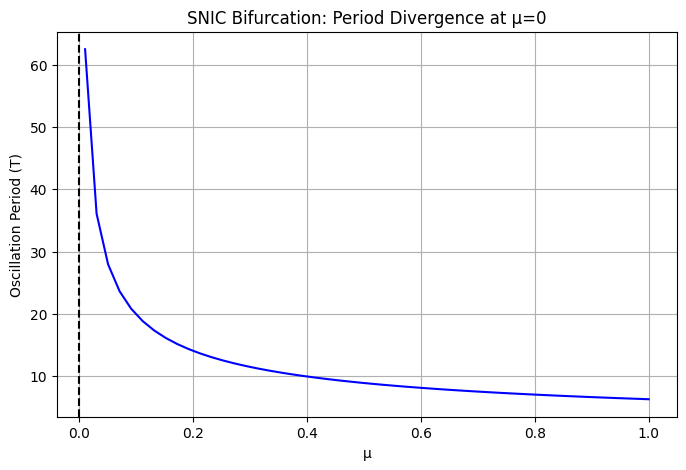

In [112]:
mu_range = np.linspace(-1, 1, 100)
periods = []

for mu_val in mu_range:
    if mu_val <= 0:
        periods.append(np.inf)  # No oscillation
    else:
        # Period scales as T ∝ 1/√μ near bifurcation
        periods.append(2 * np.pi / np.sqrt(mu_val))

plt.figure(figsize=(8, 5))
plt.plot(mu_range, periods, 'b-')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('μ')
plt.ylabel('Oscillation Period (T)')
plt.title('SNIC Bifurcation: Period Divergence at μ=0')
plt.grid()
plt.show()

In [113]:
from ipywidgets import interact

@interact(mu=(-1.0, 1.0, 0.1))
def explore_snic(mu=0.0):
    t = np.linspace(0, 50, 1000)
    sol = odeint(snic_rhs, theta0, t, args=(mu,))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(t, sol % (2*np.pi), 'b-')
    plt.xlabel('Time'); plt.ylabel('θ (mod 2π)')
    
    plt.subplot(122, projection='polar')
    plt.plot(sol % (2*np.pi), np.ones_like(sol), 'b-')
    plt.title('Phase Space')
    plt.suptitle(f'SNIC System (μ={mu:.1f})')
    plt.tight_layout()

interactive(children=(FloatSlider(value=0.0, description='mu', max=1.0, min=-1.0), Output()), _dom_classes=('w…

## Transcritical Bifurcation Analysis

A transcritical bifurcation occurs when two fixed points "exchange stability" as a parameter crosses a critical value.

$$\dot x = \mu x - x^2$$

In [125]:
from ipywidgets import interact, FloatSlider
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the transcritical system
def transcritical_rhs(x, t, mu):
    return mu * x - x**2

# Interactive plotting function
def plot_transcritical(mu):
    # Time points and initial conditions
    t = np.linspace(0, 10, 1000)
    x0_vals = [-0.5, 0.5, 1.5]  # Multiple initial conditions
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Phase portrait (x vs dx/dt)
    x = np.linspace(-1, 2, 100)
    dxdt = mu * x - x**2
    ax1.plot(x, dxdt, 'b-', label=f'$\dot x = {mu:.1f}x - x^2$')
    ax1.axhline(0, color='k', linestyle='--')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$\dot x$')
    ax1.set_title(f'Phase Portrait (μ = {mu:.1f})')
    ax1.grid(True)
    
    # Mark fixed points
    if mu < 0:
        ax1.scatter(0, 0, color='g', s=100, label='Stable (x=0)')
        ax1.scatter(mu, 0, color='r', s=100, label='Unstable (x=μ)')
    elif mu > 0:
        ax1.scatter(0, 0, color='r', s=100, label='Unstable (x=0)')
        ax1.scatter(mu, 0, color='g', s=100, label='Stable (x=μ)')
    ax1.legend()
    
    # Time series
    for x0 in x0_vals:
        sol = odeint(transcritical_rhs, x0, t, args=(mu,))
        ax2.plot(t, sol, label=f'x(0) = {x0:.1f}')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('x(t)')
    ax2.set_title('Time Series')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


In [133]:
@interact(mu=(-2.0, 2.0, 0.1))
def plot_transcritical(mu):
    x_vals = np.linspace(-1, 3, 100)
    dxdt = mu * x_vals - x_vals**2
    
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, dxdt, 'b-', label=f'$\dot x = {mu:.1f}x - x^2$')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('$\dot x$')
    plt.title(f'Transcritical Bifurcation (μ = {mu:.1f})')
    plt.grid()
    plt.legend()
    
    # Mark fixed points
    if mu < 0:
        plt.scatter(0, 0, color='g', s=100, label='Stable')
        plt.scatter(mu, 0, color='r', s=100, label='Unstable')
    elif mu > 0:
        plt.scatter(0, 0, color='r', s=100, label='Unstable')
        plt.scatter(mu, 0, color='g', s=100, label='Stable')
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='mu', max=2.0, min=-2.0), Output()), _dom_classes=('w…

## Global Bifurcations

Globally structural change (**e.g., trajectories, separatrices, or cycles** ).

Often cannot be detected from local analysis alone.

### Homoclinic Bifurcation

A trajectory that leaves and re-enters the same saddle point appears/disappears.

A homoclinic bifurcation occurs when a homoclinic orbit (a trajectory that connects a saddle equilibrium point to itself as ($t→±∞$) is created or destroyed as a parameter is varied. This leads to qualitative changes in the system's dynamics, such as the emergence or disappearance of periodic orbits, chaos, or other invariant sets.

$$\dot x = y$$

$$\dot y = \mu - sin(x) - \delta y $$

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def pendulum_system(state, t, mu, delta):
    x, y = state
    dxdt = y
    dydt = mu - np.sin(x) - delta * y
    return [dxdt, dydt]

We can use Melnikov’s method to approximate the bifurcation, if we are in weak dumping $\delta << 1$.
+ Method 1: Hamiltonian limit
The system becomes conservative, and homoclinic orbits can be computed exactly. For $μ=1$, there’s a homoclinic orbit connecting the saddle at $(x,y)=(\pi/2,0)$

+ + With dumpling
The Melnikov integral gives the first-order correction for $\mu_c$:
$$\mu_c \approx 1 - \delta \cdot C$$, where $C$ depends on the integral of the dampling term along the homoclinic orbit of the undamped system.

For our pendulum, numerical evaluation of the integral yields $\mu_c \approx 1 - \delta \cdot \frac43$

+ Numerical Detection (Shooting/BVP)
When analytical methods fail, we solve a boundary value problem (BVP) to find the homoclinic orbit.

1. fixed $\delta = 0.1$
2. Define the "return time": A homoclinic orbit takes infinite time, but numerically we integrate for a large $T$ until$y(T)$ is close to the saddle.
3. Shoot for $\mu$: Adjust $\mu$ iteratively until the trajectory ends on the stable manifold.

In [138]:
from scipy.optimize import root_scalar

def homoclinic_condition(mu, delta=0.1, T=100, tol=1e-4):
    # Saddle point (approximate for μ ≈ 1)
    saddle_x = np.arcsin(min(mu, 1.0))
    saddle_y = 0.0

    # Simulate unstable manifold (forward in time)
    ic_unstable = [saddle_x + 1e-5, saddle_y]  # Perturb into unstable manifold
    t = np.linspace(0, T, 10000)
    sol = odeint(pendulum_system, ic_unstable, t, args=(mu, delta))
    x, y = sol[-1, :]

    # Check if trajectory returned close to saddle
    return np.sqrt((x - saddle_x)**2 + (y - saddle_y)**2) - tol

# Find μ_c where homoclinic condition is zero
result = root_scalar(homoclinic_condition, bracket=[0.9, 1.1])
mu_c = result.root
print(f"Homoclinic bifurcation at μ ≈ {mu_c:.6f}")

Homoclinic bifurcation at μ ≈ 1.000000


- Method 3:  Continuation Software (Auto-07p/PyCont)
For rigorous bifurcation analysis, use specialized tools:

- - PyCont (Python): Extends scipy with continuation methods.
- - Auto-07p: Industry standard for bifurcation analysis.
 
- - PyDSTool

In [153]:
import numpy as np
from pyauto import PyAuto

# Define the system (damped pendulum with torque)
def equations(x, p):
    mu, delta = p[0], p[1]
    return [x[1], mu - np.sin(x[0]) - delta * x[1]]

# Initialize AUTO
auto = PyAuto()

# Run continuation in μ (detect bifurcations)
auto.run(
    eq=equations, 
    c='ivp',         # Initial value problem
    ICP=['mu'],      # Continuation parameter
    NMX=2000,        # Max steps
    STOP=['LP1'],    # Stop at first limit point
    UZSTOP={'mu': 1.0}  # Stop near μ=1.0 (homoclinic point)
)

# Plot bifurcation diagram
auto.plot_continuation('mu', 'x', stable='solid', unstable='dashed')

ImportError: cannot import name 'PyAuto' from 'pyauto' (C:\Users\Micro\anaconda3\envs\sakuyui39\lib\site-packages\pyauto\__init__.py)

In [151]:
from pycont import continuation

def F(X, params):
    x, y = X
    mu, delta = params
    return [y, mu - np.sin(x) - delta * y]

# Simple continuation in mu
cont_results = continuation(F, init_params=[1.0, 0.1], free_param_idx=0)

ImportError: cannot import name 'continuation' from 'pycont' (C:\Users\Micro\anaconda3\envs\sakuyui39\lib\site-packages\pycont\__init__.py)

In [152]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar

def distance_to_saddle(mu, delta=0.1, T=100):
    # Saddle point
    x_saddle = np.arcsin(min(mu, 1.0))
    
    # Simulate unstable manifold
    sol = solve_ivp(
        lambda t, X: [X[1], mu - np.sin(X[0]) - delta * X[1]],
        [0, T], 
        [x_saddle + 1e-5, 0],  # Perturb along unstable manifold
        dense_output=True
    )
    
    # Distance to saddle at t=T
    return np.linalg.norm(sol.y[:, -1] - [x_saddle, 0])

# Find μ where distance is minimized (≈ 0 for homoclinic)
res = minimize_scalar(distance_to_saddle, bounds=(0.9, 1.0), method='bounded')
mu_c = res.x
print(f"Homoclinic at μ ≈ {mu_c:.6f}")

Homoclinic at μ ≈ 0.943843


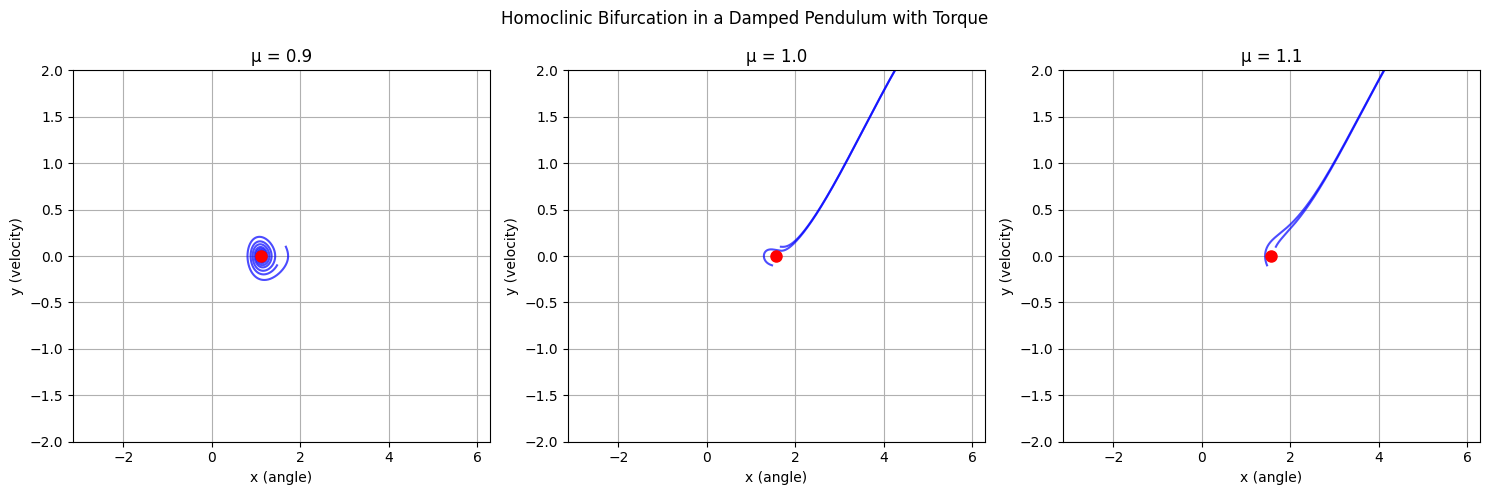

In [137]:
# Parameters
delta = 0.1  # Small damping
mu_values = [0.9, 1.0, 1.1]  # Before, at, and after bifurcation

# Time settings
t = np.linspace(0, 100, 10000)

# Initial conditions near saddle (for mu ≈ 1, saddle is at x ≈ π/2)
initial_conditions = [(np.pi/2 + 0.1, 0.1), (np.pi/2 - 0.1, -0.1)]

# Plot phase portraits
plt.figure(figsize=(15, 5))
for i, mu in enumerate(mu_values):
    plt.subplot(1, 3, i+1)
    
    # Simulate trajectories
    for ic in initial_conditions:
        sol = odeint(pendulum_system, ic, t, args=(mu, delta))
        plt.plot(sol[:, 0], sol[:, 1], 'b-', alpha=0.7)
    
    # Plot saddle point (for mu ≈ 1, it's at (arcsin(mu), 0))
    saddle_x = np.arcsin(mu) if mu <= 1 else np.pi/2
    plt.plot(saddle_x, 0, 'ro', markersize=8)  # Saddle point
    
    plt.title(f"μ = {mu}")
    plt.xlabel("x (angle)")
    plt.ylabel("y (velocity)")
    plt.grid()
    plt.xlim(-np.pi, 2*np.pi)
    plt.ylim(-2, 2)

plt.suptitle("Homoclinic Bifurcation in a Damped Pendulum with Torque")
plt.tight_layout()
plt.show()

### Heteroclinic Bifurcation

A trajectory connects two different saddle points and this connection changes.

A trajectory that leaves one saddle equilibrium along its unstable manifold and approaches another saddle along its stable manifold as $t→±∞$.

Forms a "connection" between two distinct saddles.

In [154]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lotka_volterra(t, state, alpha, beta):
    x, y = state
    dxdt = x * (1 - x - alpha * y)
    dydt = y * (1 - y - beta * x)
    return [dxdt, dydt]

In [155]:
# Saddle points: (1, 0) and (0, 1)
saddle1 = np.array([1.0, 0.0])
saddle2 = np.array([0.0, 1.0])

In [156]:
def jacobian(x, y, alpha, beta):
    return np.array([
        [1 - 2*x - alpha*y, -alpha*x],
        [-beta*y, 1 - 2*y - beta*x]
    ])

# Eigenvectors at saddle1 (unstable manifold)
J1 = jacobian(1, 0, alpha=2, beta=2)
eigvals1, eigvecs1 = np.linalg.eig(J1)
unstable_dir1 = eigvecs1[:, np.argmax(eigvals1)]  # Unstable eigenvector

# Eigenvectors at saddle2 (stable manifold)
J2 = jacobian(0, 1, alpha=2, beta=2)
eigvals2, eigvecs2 = np.linalg.eig(J2)
stable_dir2 = eigvecs2[:, np.argmin(eigvals2)]    # Stable eigenvector

In [157]:
alpha, beta = 2.0, 2.0  # Initial guess
T = 100  # Long integration time

# Perturb from saddle1 along unstable manifold
eps = 1e-5
ic = saddle1 + eps * unstable_dir1

# Simulate trajectory
sol = solve_ivp(
    lotka_volterra, 
    [0, T], 
    ic, 
    args=(alpha, beta),
    dense_output=True
)

# Check if trajectory approaches saddle2
distance_to_saddle2 = np.linalg.norm(sol.y[:, -1] - saddle2)
print(f"Distance to saddle2: {distance_to_saddle2:.2e}")

Distance to saddle2: 1.41e+00


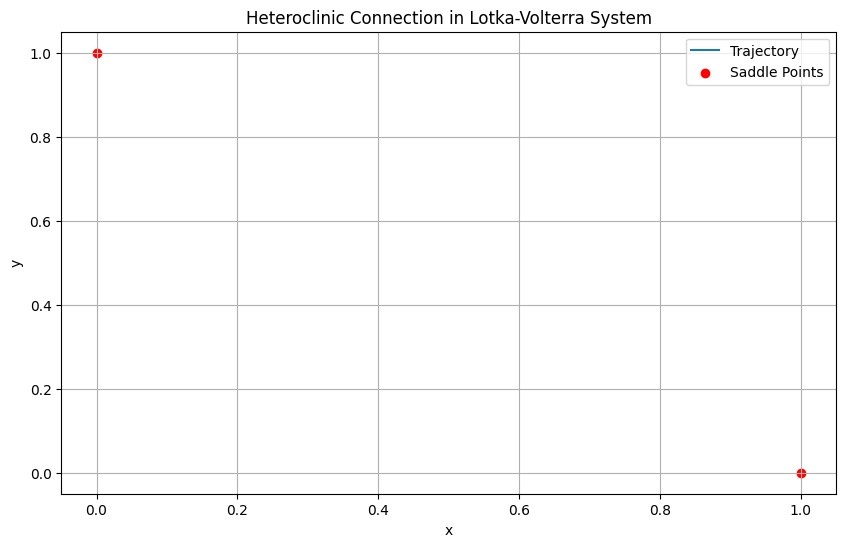

In [164]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lotka_volterra(t, state, alpha, beta):
    x, y = state
    dxdt = x * (1 - x - alpha * y)
    dydt = y * (1 - y - beta * x)
    return [dxdt, dydt]

# Parameters where heteroclinic connection exists (theoretical)
alpha = 1.0
beta = 1.0

# Integration settings
t_span = [0, 100]
t_eval = np.linspace(*t_span, 1000)

# Initial condition near (1,0) perturbed towards (0,1)
eps = 1e-5
ic = [1 - eps, eps]

# Solve system
sol = solve_ivp(lotka_volterra, t_span, ic, args=(alpha, beta), 
                t_eval=t_eval, method='RK45')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sol.y[0], sol.y[1], label='Trajectory')
plt.scatter([0, 1], [1, 0], c='red', label='Saddle Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heteroclinic Connection in Lotka-Volterra System')
plt.legend()
plt.grid()
plt.show()

### SNIC (Saddle-Node on Invariant Circle)

A saddle-node bifurcation occurs on a periodic orbit, often seen in neuroscience.